In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize(256),transforms.RandomCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.ImageFolder('/home/greeshma/Downloads/inaturalist_12K/train', transform=transform)
test_dataset = datasets.ImageFolder('/home/greeshma/Downloads/inaturalist_12K/val', transform=transform)



<class 'torchvision.datasets.folder.ImageFolder'>


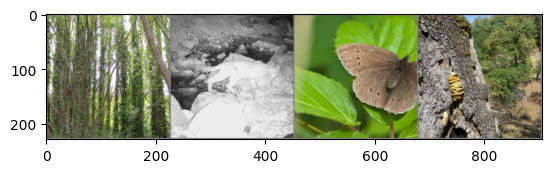

: 

: 

In [2]:
print(type(train_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

classes = ('Fungi', 'Amphibia', 'Animalia', 'Mammalia', 'Aves', 'Mollusca', 'Reptilia', 'Plantae', 'Insecta', 'Arachnida')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 120, 5)
        self.conv2 = nn.Conv2d(120, 100, 5)
        self.conv3 = nn.Conv2d(100, 80, 5)
        self.conv4 = nn.Conv2d(80, 50, 5)
        self.conv5 = nn.Conv2d(50, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(44944, 40000)
        self.fc2 = nn.Linear(40000, 20000)
        self.fc3 = nn.Linear(20000, 10000)
        self.fc4 = nn.Linear(10000, 5000)
        self.fc5 = nn.Linear(50000, 2000)
        self.fc6 = nn.Linear(2000, 500)
        self.fc7 = nn.Linear(500, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))  # -> n, 16, 5, 5
        x = x.view(-1,44944)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))   
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = F.relu(self.fc5(x)) 
        x = F.relu(self.fc6(x))            # -> n, 84
        x = self.fc7(x)                       # -> n, 10+
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
